In [1]:
#import things
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen
import charts_function_list
import os
import seaborn as sns
from matplotlib.patches import Ellipse
import viz_functions

In [8]:
#set up some folders
base,data,outputs = charts_function_list.folder_setup()

#read our dataset of
os.chdir(data)
tall_football = pd.read_csv('tallest football players.csv')

#fix some inconsistencies btw sets
tall_football = tall_football.replace({'Position':{'S':'DB',
                                  'CB':'DB'}})

#remove the duplicates that come up as a result
tall_football = tall_football.sort_values(by=['Position','Weight','Height'],ascending=False).drop_duplicates(subset='Position')

#resort for ideal visualization. First by the height, then by the position
tall_football = tall_football.sort_values(by=['Height','Position'],ascending=True).reset_index(drop=True)

#create functions to pull data from nfl.com

#this one pulls the beautifulsoup read of the site
def url_pull(team_abbrev):
    url = 'http://www.nfl.com/teams/roster?d-447263-n=1&team='+team_abbrev+'&d-447263-o=2&d-447263-p=1&d-447263-'
    html = urlopen(url)
    soup = BeautifulSoup(html,"lxml")
    return soup

#setup a dataframe from the pulled page
def frame_setup(soup):
    headers = [th.get_text() for th in soup.select('tr')[1].find_all("th")] #get header list
    headers = [x.strip('\n') for x in headers] #remove space
    rows = soup.select('tr')[2:]
    row_text = [th.get_text() for th in rows]
    row_frame = pd.DataFrame([row_text[x].split('\n')[1:] for x in range(len(row_text))],columns=headers)
    heights = [(int(x),int(y.strip("\""))) for x,y in row_frame['Height'].str.strip().str.split("'")]
    row_frame['Inches'] = [(x[0]*12)+(x[1]) for x in heights]
    return row_frame

stew = []
error_list = []
team_list = ['ari','atl','buf','car','chi','cin',
             'bal','cle','dal','den','det','pit','gb','hou','ind','jax','kc','lac','la','min',
            'mia','ne','nyg','nyj','oak','phi','sf','sea','tb','ten','was','no']


#create dataframe for all nfl teams. Uses an error list to identify incorrect team abbreviations. Error list has no use at this point
for team in team_list:
    soup = url_pull(team)
    try:
        stew.append(frame_setup(soup))
    except:
        error_list.append(team)
        
full_nfl_frame = pd.concat(stew)

#reconcile positions between datasets
full_nfl_frame = full_nfl_frame.replace({'Pos':{'S':'DB',
                                                   'CB':'DB',
                                                     'FS':'DB',
                                                     'ILB':'LB',
                                                     'MLB':'LB',
                                                     'C':'OL',
                                                'OLB':'LB',
                                                'OT':'OL',
                                                'SS':'DB',
                                                'SAF':'DB',
                                                'OG':'OL',
                                                'NT':'DT'
                                                
                                                    }})


#remove position that don't have heights listed in the tall list
remove_list = ['FB','LS']

#create new frame without positions getting dropped
full_nfl_frame = full_nfl_frame[~full_nfl_frame['Pos'].isin(remove_list)].copy()

#create an sort order based on the tallest ever
sort_order = {k:v for k,v in zip(tall_football['Position'].values,tall_football.index.values)}
full_nfl_frame['Sort_Order'] = full_nfl_frame['Pos'].map(sort_order)
full_nfl_frame  = full_nfl_frame.sort_values(by=['Sort_Order','Inches']).reset_index(drop=True)

In [317]:
full_nfl_frame.groupby('Pos').max()['Height']

Pos
DB     6'4"
DE     6'8"
DT     6'7"
K      6'5"
LB     6'7"
OL     6'9"
P      6'6"
QB     6'7"
RB     6'3"
TE     6'8"
WR     6'5"
Name: Height, dtype: object

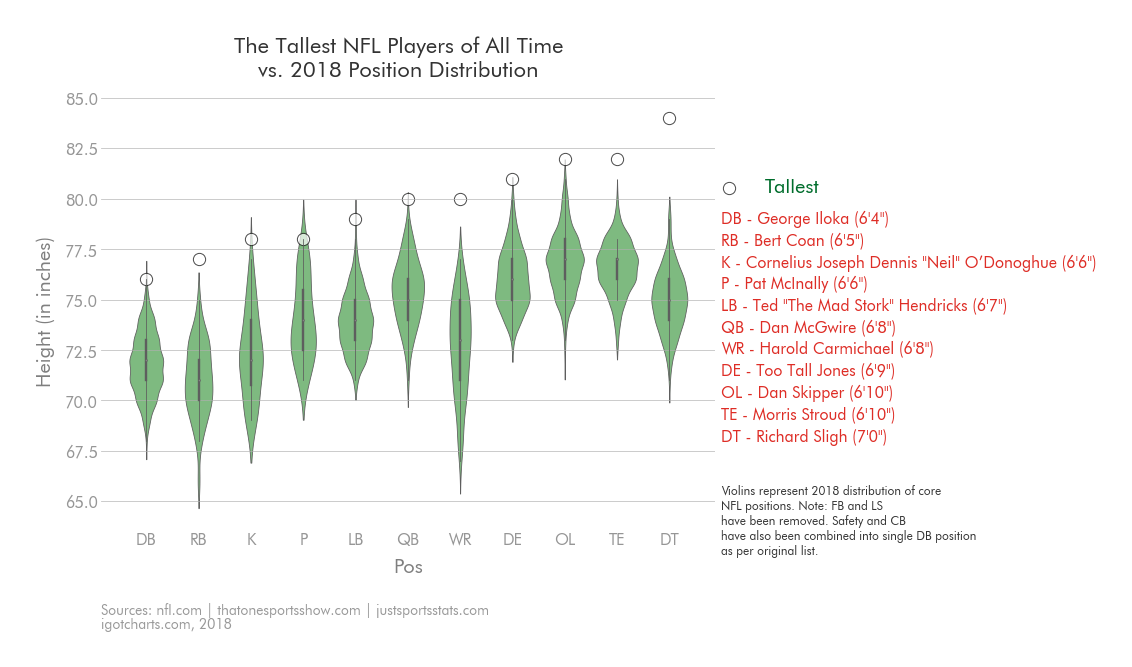

In [315]:
#create chart
violins = viz_functions.chart_maker(title='The Tallest NFL Players of All Time\nvs. 2018 Position Distribution',title_size=22)
fig = violins.initial_fig_axis()
ax = plt.subplot()
ax.grid(alpha=.8,)
#set violins' width based on count
sns.violinplot(x='Pos',y='Inches',data=full_nfl_frame,color='#74c476',linewidth=.8)
ax.scatter(tall_football.index,tall_football.Height,facecolor='white',edgecolor='black',s=150,alpha=.7,label='Tallest')
ax.set_xlabel(ax.get_xlabel(),size=20,alpha=.5)
ax.set_ylabel('Height (in inches)',size=20,alpha=.5)

violins.tick_params_(ax=ax)
position_labels = tall_football['Position']+' - '+tall_football['Player']+" ("+tall_football['Ft'].astype('str')+"'"+\
tall_football['Inches'].astype('str')+"\")"


    
for i,v in enumerate(position_labels):
    ax.text(1.01,.7-(i/20),v,transform=ax.transAxes,color="#de2d26",fontsize=16)

violins.citations(ax=ax,source='Sources: nfl.com | thatonesportsshow.com | justsportsstats.com',
                  chart_tag='igotcharts.com, 2018',source_y=-.2,chart_tag_y=-.23)

leg = ax.legend(bbox_to_anchor=(.96,.72),loc=3,fontsize=20,)
for text in leg.get_texts():
    text.set_color("#006d2c")
    

ax.text(1.01,.1,'Violins represent 2018 distribution of core\nNFL positions. Note: FB and LS\nhave been removed. Safety and CB\nhave also been combined into single DB position\nas per original list.',transform=ax.transAxes,fontsize=12,va='top',alpha=.8)
os.chdir(outputs)
charts_function_list.chart_save('NFL_tallest')

In [ ]:
#test to see unmatching positions between datasets

#compare positions
current_position = set(full_nfl_frame['Pos'].unique())
tall_list = set(tall_football['Position'].unique())
print('Mismatch btw Tall List and Current Players: '+str(list(tall_list - current_position)))
print('Current Players and Mismatch btw Tall List: '+str(list(current_position-tall_list)))